# NiN

ps：

pip install d2l

pip install matplotlib==3.0.0

回想一下，卷积层的输入和输出由四维张量组成，张量的每个轴分别对应样本、通道、高度和宽度。另外， 全连接层的输入和输出通常是分别对应于样本和特征的二维张量。NiN的想法是在每个像素位置(针对每个 高度和宽度)应用一个全连接层。如果我们将权重连接到每个空间位置，我们可以将其视为1 × 1卷积层(如 6.4节中所述)，或作为在每个像素位置上独立作用的全连接层。从另一个⻆度看，即将空间维度中的每个像 素视为单个样本，将通道维度视为不同特征(feature)。

![title](attachment/nin.png)

图7.3.1说明了VGG和NiN及它们的块之间主要架构差异。NiN块以一个普通卷积层开始，后面是两个1 × 1的 卷积层。这两个1 × 1卷积层充当带有ReLU激活函数的逐像素全连接层。第一层的卷积窗口形状通常由用戶 设置。随后的卷积窗口形状固定为1 × 1。


最初的NiN网络是在AlexNet后不久提出的，显然从中得到了一些启示。NiN使用窗口形状为11 × 11、5 × 5和3 × 3的卷积层，输出通道数量与AlexNet中的相同。每个NiN块后有一个最大汇聚层，汇聚窗口形状为3 × 3，步 幅为2。


NiN和AlexNet之间的一个显著区别是NiN完全取消了全连接层。相反，NiN使用一个NiN块，其输出通道数等 于标签类别的数量。最后放一个全局平均汇聚层(global average pooling layer)，生成一个对数几率(logits)。 NiN设计的一个优点是，它显著减少了模型所需参数的数量。然而，在实践中，这种设计有时会增加训练模 型的时间。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

- NiN_block

In [2]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding): 
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
    nn.ReLU(),
    nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
    nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

1. 定义网络

In [3]:
net = nn.Sequential(
  nin_block(1, 96, kernel_size=11, strides=4, padding=0), 
  nn.MaxPool2d(3, stride=2),
  nin_block(96, 256, kernel_size=5, strides=1, padding=2), 
  nn.MaxPool2d(3, stride=2),
  nin_block(256, 384, kernel_size=3, strides=1, padding=1), 
  nn.MaxPool2d(3, stride=2),
  nn.Dropout(0.5),
  # 标签类别数是10
  nin_block(384, 10, kernel_size=3, strides=1, padding=1), 
  nn.AdaptiveAvgPool2d((1, 1)),
  # 将四维的输出转成二维的输出，其形状为(批量大小,10) 
  nn.Flatten())

In [4]:
X = torch.rand(size=(1, 1, 224, 224)) 
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [5]:
# 2. 载入数据集
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

# 3. 初始化weight

def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

# 4. 定义loss

l = nn.CrossEntropyLoss()

# 5. 定义优化器

o = torch.optim.SGD(net.parameters(), lr=0.05)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


6. Training and Prediction

In [6]:
def acc(X,y,net):
  p_predict = net(X)
  y_predict = torch.argmax(p_predict,axis=1)
  output = y_predict - y
  right_pre = len(output[output==0])
  right_accu = right_pre/len(output)
  return right_accu

def eval_accu(net=None, dataset=None, cuda=False):
  
  accu = 0
  batch = 0
  net.eval()

  for X,y in dataset:
    if cuda:
      net.cuda()
      X,y = X.cuda(),y.cuda()
    accu += acc(X, y, net)
    batch += 1
  avg_acc = accu/batch

  return avg_acc

def train_net(net=None, epochs=10, loss = None, optimizer=None, 
              train_iter=None, test_iter=None, cuda=False):
  train_accu_history = []
  test_accu_history = []
  train_loss = []

  for epoch in range(epochs):

    net.train()
    for X,y in train_iter:
      if cuda:
        net.cuda()
        X,y = X.cuda(),y.cuda()
      l = loss(net(X), y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()

    net.eval() 
    l = loss(net(X), y)
    train_loss.append(l.cpu().detach())
    

    train_avg_acc = eval_accu(net, train_iter, cuda)
    test_avg_acc = eval_accu(net, test_iter, cuda)
    train_accu_history.append(train_avg_acc)
    test_accu_history.append(test_avg_acc)

    print(f'epoch {epoch + 1}, loss {l:f}, train_accu {train_avg_acc:f}, test_accu {test_avg_acc:f}')
  
  x_label_value = [str(i) for i in range(1,epochs+1)]
  plt.plot(x_label_value, train_accu_history, label='train_accu', color='g', linestyle='dashed')
  plt.plot(x_label_value, test_accu_history, label='test_accu', color='r', linestyle='dashed')
  plt.plot(x_label_value, train_loss, label='train_loss', color='b')
  plt.xlabel('epoch')
  plt.ylim(0.1,2)
  plt.legend()
  plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1, loss 2.253298, train_accu 0.182958, test_accu 0.182936
epoch 2, loss 1.192538, train_accu 0.477840, test_accu 0.477834
epoch 3, loss 0.790754, train_accu 0.726929, test_accu 0.726968
epoch 4, loss 0.638407, train_accu 0.790695, test_accu 0.790689
epoch 5, loss 0.391801, train_accu 0.804649, test_accu 0.804621
epoch 6, loss 0.275933, train_accu 0.833300, test_accu 0.833306
epoch 7, loss 0.351656, train_accu 0.857459, test_accu 0.857432
epoch 8, loss 0.337220, train_accu 0.858426, test_accu 0.858420
epoch 9, loss 0.344777, train_accu 0.871630, test_accu 0.871652
epoch 10, loss 0.247570, train_accu 0.871146, test_accu 0.871163


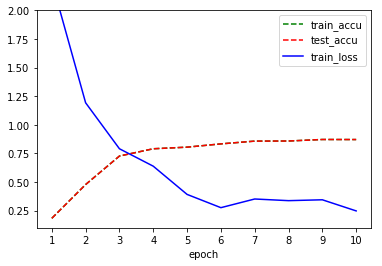

CPU times: user 38min 53s, sys: 1min 49s, total: 40min 42s
Wall time: 45min 39s


In [7]:
%%time
train_net(net=net, epochs=10, loss = l, optimizer=o, 
          train_iter=train_iter, test_iter=train_iter, cuda=True)